# CoT Based Smart Web Search

- Author: [syshin0116](https://github.com/syshin0116)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/15-CoT-basedSmartWebSearch.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/15-CoT-basedSmartWebSearch.ipynb)

## Overview

This tutorial demonstrates a chain-of-thought (CoT) based Smart Web Search approach to build a plan-and-execute style QA chatbot. We will also explore the LLMCompiler method for speed optimization.

### Key Features
- Chain-of-Thought guided query expansion and reasoning
- Dynamic plan-and-execute system for multi-step web search
- Integration with LLMCompiler for accelerated pipeline



## LLM Compiler

- Proposed by Kim et al. as a high-speed, execution-oriented agent architecture
- Core Components
    - **Planner**
        - Generates tasks in a DAG (Directed Acyclic Graph) format via streaming
    - **Task Fetching Unit**
        - Consumes the Planner’s list of tasks, executing each as soon as dependencies are met
        - Supports parallel execution
    - **Joiner**
        - Collects results from all tasks and decides whether to produce a final answer or replan
- Key Characteristics
    - Allows streaming of tasks so certain tasks can be executed even before the Planner finishes building out the full plan
    - Executes all dependency-free tasks in parallel to reduce overall runtime
    - Provides fast responses with minimal large-model usage


### What is a DAG?

A **DAG (Directed Acyclic Graph)** is a common structure in computing and data processing

- **Directed**
    - Every edge in the graph has a direction
    - For instance, A → B means you can only move from A to B
- **Acyclic**
    - The graph contains no cycles
    - There is no path that starts at one node and eventually returns to it
- **Graph**
    - Composed of nodes and edges
    - Nodes represent data or tasks, and edges define how they relate to or depend on each other


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [...](#...)

### References

- [Language Agent Tree Search Unifies Reasoning Acting and Planning in Language Models](https://arxiv.org/abs/2310.04406)
- [Building (and Breaking) WebLangChain](https://blog.langchain.dev/weblangchain/)
- [Plan-and-Execute Agents](https://blog.langchain.dev/planning-agents/)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

## 리뷰어님들을 위한 설명

### 튜토리얼 주요 목적
- Perplexity와 유사한 CoT 기반 검색 QA(Chatbot) 구현
- Plan-Execute 방식을 바탕으로 LLMCompiler를 추가 적용하여 속도 최적화 시도

### 현재 코드 상태
- 코드가 두 부분으로 나뉘어 있음 (LLMCompiler 방식 / Plan & Schedule 방식)

### 추가 예정 항목
- Plan & Schedule 방식에 LLM Compiler 코드 통합
- LangChain 공식 Config 설정 방식으로 변경
- 설명, 주석 추가
- Prompt 수정
- Summarizer, Output Parser 고도화 및 최종 QA 결과 최적화
- LangSmith 오류 해결

    `Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)`

### 추가 가능성 항목
- VectorDB 검색, Knowledge Graph 검색, Web Search API 등 툴 추가
- 이미지 검색

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain-anthropic",
        "langchain_community",
        "langchain_text_splitters",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    ["duckduckgo-search"],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "COT-based-smart-websearch",
        "TAVILY_API_KEY": "",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [5]:
# import for asynchronous tasks
import asyncio
import nest_asyncio

nest_asyncio.apply()

## LLM Compiler

LLMCompiler is an agent architecture designed to speed up the execution of agentic tasks by eagerly-executed tasks within a DAG. It also saves costs on redundant token usage by reducing the number of calls to the LLM. Below is an overview of its computational graph:

![LLM Compiler](./assets/15-CoT-basedSmartWebSearch-01.png)

It has 3 main components:

Planner: stream a DAG of tasks.
Task Fetching Unit: schedules and executes the tasks as soon as they are executable
Joiner: Responds to the user or triggers a second plan

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

# from langchain_community.tools import DuckDuckGoSearchResults

# search = DuckDuckGoSearchResults(
#     description='duckduckgo_search_results_json(query="the search query") - a search engine.',
# )

tools = [search]

In [7]:
print(search.invoke("weather in seoul"))

[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Seoul', 'region': '', 'country': 'South Korea', 'lat': 37.5664, 'lon': 126.9997, 'tz_id': 'Asia/Seoul', 'localtime_epoch': 1737893172, 'localtime': '2025-01-26 21:06'}, 'current': {'last_updated_epoch': 1737892800, 'last_updated': '2025-01-26 21:00', 'temp_c': 5.0, 'temp_f': 41.0, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 3.6, 'wind_kph': 5.8, 'wind_degree': 109, 'wind_dir': 'ESE', 'pressure_mb': 1022.0, 'pressure_in': 30.18, 'precip_mm': 0.01, 'precip_in': 0.0, 'humidity': 48, 'cloud': 0, 'feelslike_c': 3.8, 'feelslike_f': 38.8, 'windchill_c': 1.6, 'windchill_f': 34.8, 'heatindex_c': 3.1, 'heatindex_f': 37.5, 'dewpoint_c': -5.9, 'dewpoint_f': 21.5, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 0.0, 'gust_mph': 5.5, 'gust_kph': 8.8}}"}]


### Output parser

In [8]:
import ast
import re
from typing import (
    Any,
    Dict,
    Iterator,
    List,
    Optional,
    Sequence,
    Tuple,
    Union,
)

from langchain_core.exceptions import OutputParserException
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers.transform import BaseTransformOutputParser
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import BaseTool
from typing_extensions import TypedDict

THOUGHT_PATTERN = r"Thought: ([^\n]*)"
ACTION_PATTERN = r"\n*(\d+)\. (\w+)\((.*)\)(\s*#\w+\n)?"
# $1 or ${1} -> 1
ID_PATTERN = r"\$\{?(\d+)\}?"
END_OF_PLAN = "<END_OF_PLAN>"


### Helper functions


def _ast_parse(arg: str) -> Any:
    try:
        return ast.literal_eval(arg)
    except:  # noqa
        return arg


def _parse_llm_compiler_action_args(args: str, tool: Union[str, BaseTool]) -> list[Any]:
    """Parse arguments from a string."""
    if args == "":
        return ()
    if isinstance(tool, str):
        return ()
    extracted_args = {}
    tool_key = None
    prev_idx = None
    for key in tool.args.keys():
        # Split if present
        if f"{key}=" in args:
            idx = args.index(f"{key}=")
            if prev_idx is not None:
                extracted_args[tool_key] = _ast_parse(
                    args[prev_idx:idx].strip().rstrip(",")
                )
            args = args.split(f"{key}=", 1)[1]
            tool_key = key
            prev_idx = 0
    if prev_idx is not None:
        extracted_args[tool_key] = _ast_parse(
            args[prev_idx:].strip().rstrip(",").rstrip(")")
        )
    return extracted_args


def default_dependency_rule(idx, args: str):
    matches = re.findall(ID_PATTERN, args)
    numbers = [int(match) for match in matches]
    return idx in numbers


def _get_dependencies_from_graph(
    idx: int, tool_name: str, args: Dict[str, Any]
) -> dict[str, list[str]]:
    """Get dependencies from a graph."""
    if tool_name == "join":
        return list(range(1, idx))
    return [i for i in range(1, idx) if default_dependency_rule(i, str(args))]


class Task(TypedDict):
    idx: int
    tool: BaseTool
    args: list
    dependencies: Dict[str, list]
    thought: Optional[str]


def instantiate_task(
    tools: Sequence[BaseTool],
    idx: int,
    tool_name: str,
    args: Union[str, Any],
    thought: Optional[str] = None,
) -> Task:
    if tool_name == "join":
        tool = "join"
    else:
        try:
            tool = tools[[tool.name for tool in tools].index(tool_name)]
        except ValueError as e:
            raise OutputParserException(f"Tool {tool_name} not found.") from e
    tool_args = _parse_llm_compiler_action_args(args, tool)
    dependencies = _get_dependencies_from_graph(idx, tool_name, tool_args)

    return Task(
        idx=idx,
        tool=tool,
        args=tool_args,
        dependencies=dependencies,
        thought=thought,
    )


class LLMCompilerPlanParser(BaseTransformOutputParser[dict], extra="allow"):
    """Planning output parser."""

    tools: List[BaseTool]

    def _transform(self, input: Iterator[Union[str, BaseMessage]]) -> Iterator[Task]:
        texts = []
        # TODO: Cleanup tuple state tracking here.
        thought = None
        for chunk in input:
            # Assume input is str. TODO: support vision/other formats
            text = chunk if isinstance(chunk, str) else str(chunk.content)
            for task, thought in self.ingest_token(text, texts, thought):
                yield task
        # Final possible task
        if texts:
            task, _ = self._parse_task("".join(texts), thought)
            if task:
                yield task

    def parse(self, text: str) -> List[Task]:
        return list(self._transform([text]))

    def stream(
        self,
        input: str | BaseMessage,
        config: RunnableConfig | None = None,
        **kwargs: Any | None,
    ) -> Iterator[Task]:
        yield from self.transform([input], config, **kwargs)

    def ingest_token(
        self, token: str, buffer: List[str], thought: Optional[str]
    ) -> Iterator[Tuple[Optional[Task], str]]:
        buffer.append(token)
        if "\n" in token:
            buffer_ = "".join(buffer).split("\n")
            suffix = buffer_[-1]
            for line in buffer_[:-1]:
                task, thought = self._parse_task(line, thought)
                if task:
                    yield task, thought
            buffer.clear()
            buffer.append(suffix)

    def _parse_task(self, line: str, thought: Optional[str] = None):
        task = None
        if match := re.match(THOUGHT_PATTERN, line):
            # Optionally, action can be preceded by a thought
            thought = match.group(1)
        elif match := re.match(ACTION_PATTERN, line):
            # if action is parsed, return the task, and clear the buffer
            idx, tool_name, args, _ = match.groups()
            idx = int(idx)
            task = instantiate_task(
                tools=self.tools,
                idx=idx,
                tool_name=tool_name,
                args=args,
                thought=thought,
            )
            thought = None
        # Else it is just dropped
        return task, thought

## Planner

In [9]:
from typing import Sequence

from langchain import hub
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

prompt = hub.pull("wfh/llm-compiler")
print(prompt.pretty_print())

================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

In [10]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate
):
    tool_descriptions = "\n".join(
        f"{i+1}. {tool.description}\n"
        for i, tool in enumerate(
            tools
        )  # +1 to offset the 0 starting index, we want it count normally from 1.
    )
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools)
        + 1,  # Add one because we're adding the join() tool at the end.
        tool_descriptions=tool_descriptions,
    )
    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools) + 1,
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
        RunnableBranch(
            (should_replan, wrap_and_get_last_index | replanner_prompt),
            wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

In [11]:
llm = ChatOpenAI(model="gpt-4o")
# This is the primary "agent" in our application
planner = create_planner(llm, tools, prompt)

In [12]:
from pprint import pprint
example_question = "What's the temperature in SF raised to the 3rd power?"

for task in planner.stream([HumanMessage(content=example_question)]):
    # print(task["tool"], task["args"])
    pprint(task['tool'])
    print("---")

TavilySearchResults(description='tavily_search_results_json(query="the search query") - a search engine.', max_results=1, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))
---
'join'
---


## Task Fetching Unit

In [13]:
import re
import time
from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union

from langchain_core.runnables import (
    chain as as_runnable,
)
from typing_extensions import TypedDict


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"

    def replace_match(match):
        # If the string is ${123}, match.group(0) is ${123}, and match.group(1) is 123.

        # Return the match group, in this case the index, from the string. This is the index
        # number we get back.
        idx = int(match.group(1))
        return str(observations.get(idx, match.group(0)))

    # For dependencies on other tasks
    if isinstance(arg, str):
        return re.sub(ID_PATTERN, replace_match, arg)
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    args_for_tasks = {}
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            args_for_tasks[task["idx"]] = task["args"]
            if (
                # Depends on other tasks
                deps
                and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke, dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], args_for_tasks[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(
            name=name,
            content=str(obs),
            additional_kwargs={"idx": k, "args": task_args},
            tool_call_id=k,
        )
        for k, (name, task_args, obs) in new_observations.items()
    ]
    return tool_messages

In [14]:
import itertools


@as_runnable
def plan_and_schedule(state):
    messages = state["messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"messages": scheduled_tasks}

### Example Plan

In [15]:
tool_messages = plan_and_schedule.invoke(
    {"messages": [HumanMessage(content=example_question)]}
)["messages"]

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


In [16]:
tool_messages

[FunctionMessage(content="[{'url': 'https://www.wunderground.com/weather/us/ca/san-francisco', 'content': 'San Francisco, CA Weather Conditions | Weather Underground San Francisco, CA Weather Conditions_star_rate__home_ 56\\xa0°F South of Market Station|Report Report Station You are about to report this weather station for bad data. Personal Weather Station Nearby Weather Stations Nearby Weather Stations The time period when the sun is no more than 6 degrees below the horizon at either sunrise or sunset. The time period when the sun is between 6 and 12 degrees below the horizon at either sunrise or sunset. The time period when the sun is between 12 and 18 degrees below the horizon at either sunrise or sunset. The sun does not contribute to the illumination of the sky before this time in the morning, or after this time in the evening.'}]", additional_kwargs={'idx': 1, 'args': {'query': 'current temperature in San Francisco'}}, response_metadata={}, name='tavily_search_results_json', too

## Joiner

In [17]:
from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field


class FinalResponse(BaseModel):
    """The final response/answer."""

    response: str


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""

    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]


joiner_prompt = hub.pull("wfh/llm-compiler-joiner").partial(
    examples=""
)  # You can optionally add examples
llm = ChatOpenAI(model="gpt-4-turbo-preview")

runnable = joiner_prompt | llm.with_structured_output(
    JoinOutputs, method="function_calling"
)

In [18]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return {
            "messages": response
            + [
                SystemMessage(
                    content=f"Context from last attempt: {decision.action.feedback}"
                )
            ]
        }
    else:
        return {"messages": response + [AIMessage(content=decision.action.response)]}


def select_recent_messages(state) -> dict:
    messages = state["messages"]
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

In [19]:
input_messages = [HumanMessage(content=example_question)] + tool_messages

In [20]:
joiner.invoke({"messages": input_messages})

{'messages': [AIMessage(content="Thought: The temperature in San Francisco is reported as 56°F. To answer the user's question, this value needs to be raised to the 3rd power.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='The temperature in San Francisco, raised to the 3rd power, is 56^3 = 175,616°F.', additional_kwargs={}, response_metadata={})]}

## LangGraph Usage

In [21]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    "join",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
graph_builder.add_edge(START, "plan_and_schedule")
chain = graph_builder.compile()

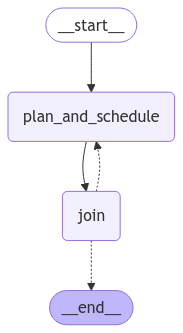

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        chain.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Simple Question

In [23]:
for step in chain.stream(
    {"messages": [HumanMessage(content="What's the GDP of New York?")]}
):
    print(step)
    print("---")

# Final answer
print(step["join"]["messages"][-1].content)

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content='[{\'url\': \'https://usafacts.org/answers/what-is-the-gross-domestic-product-gdp/state/new-york/\', \'content\': "What is the gross domestic product (GDP) in New York? What is the gross domestic product (GDP) in New York? Gross domestic product (GDP) measures the value of goods and services a country or state produces — it’s the sum of consumer spending, business investment, government spending, and net exports. As of 2023, the real GDP was $1.8 trillion. Real GDP in New York, adjusted for inflation (chained 2017 dollars) GDP and the economic experience vary by location due to factors like cost of living, population density, workforce education, and the area’s main industries. In 2023, New York\'s real (that is, inflation-adjusted) GDP per person was 1st out of all 50 states. In 2023, New York ranked 1st in state GDP per person."}]', additional_kwargs={'idx': 1, 'args': {'query': 'GDP of New York 2023'}}, response_metadata={}

### Multi-hop question

In [24]:
steps = chain.stream(
    {
        "messages": [
            HumanMessage(
                content="What's the oldest parrot alive, and how much longer is that than the average?"
            )
        ]
    },
    {
        "recursion_limit": 100,
    },
)
for step in steps:
    print(step)
    print("---")

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://www.reptileknowledge.com/reptile-pedia/what-is-the-oldest-living-bird-in-2023', 'content': 'What is the longest living pet bird? In general, the smaller the bird, the shorter its lifespan. The smaller psittacines, like budgies, parakeets, and cockatiels, generally only live 8-15 years, while the larger birds, like macaws and grey parrots, can live 25-50 years. The oldest known parrot was a cockatoo, at least 82 years old at its death. Takedown request View complete answer on'}]", additional_kwargs={'idx': 1, 'args': {'query': 'oldest parrot alive 2023'}}, response_metadata={}, name='tavily_search_results_json', id='b6e06cec-056a-4e03-b66a-6910f02061a2', tool_call_id=1), FunctionMessage(content="[{'url': 'https://www.herebird.com/how-long-do-parrots-live/', 'content': 'Discover the average lifespan of a parrot from our research into 64 parrot lifespans. Plus uncover the reason why do parrots live so long. ...

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://pets.thenest.com/average-lifespan-parrots-6518.html', 'content': 'African grey parrots, which are renowned for their speaking ability, have a lifespan of about 40 years, and some African greys live beyond the age of 60. Amazon parrots, which include yellow-headed and blue-fronted Amazons, have an average lifespan between 25 and 50 years. Macaws also have an average lifespan of 25 to 50 years.'}]", additional_kwargs={'idx': 4, 'args': {'query': 'average lifespan of parrots'}}, response_metadata={}, name='tavily_search_results_json', id='d4cff0fa-ad9c-47d6-9452-a21fd03893d8', tool_call_id=4), FunctionMessage(content='join', additional_kwargs={'idx': 5, 'args': ()}, response_metadata={}, name='join', id='4058511d-4f16-4616-8359-f6d0a10fcf37', tool_call_id=5)]}}
---
{'join': {'messages': [AIMessage(content="Thought: The information now includes specific lifespan data for several parrot species, including African

In [25]:
# Final answer
print(step["join"]["messages"][-1].content)

The oldest known parrot was a cockatoo, at least 82 years old at its death. While specific lifespan data varies by species—African grey parrots can live 40-60 years, Amazon parrots and Macaws 25-50 years—these figures suggest that the oldest parrot lived significantly longer than the average lifespan of various parrot species, which ranges broadly from 25 to 60 years depending on the species. Thus, the oldest parrot lived at least 22 years longer than the higher end of the average lifespan for many parrot species.


In [36]:
for step in chain.stream(
    {
        "messages": [
            HumanMessage(
                content="How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?"
            )
        ]
    }
):
    pprint(step)

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content='[{\'url\': \'https://www.financecharts.com/stocks/MSFT/summary/market-cap\', \'content\': "The current market cap or net worth for Microsoft (MSFT) stock is $3.178T as of Tuesday, January 21 2025. It\'s decreased by 1.80% over the past 30 days. MSFT has improved its market cap by 7.84% over the past 12 months."}]', additional_kwargs={'idx': 1, 'args': {'query': 'Microsoft current market cap 2023'}}, response_metadata={}, name='tavily_search_results_json', id='8600fad5-05bf-4d09-a60c-e3e996c675e2', tool_call_id=1),
                                    FunctionMessage(content="[{'url': 'https://www.statmuse.com/money/ask/apple-market-cap-in-2023', 'content': 'On December 29, Apple (AAPL) had a market capitalization of $3T, based on 15.58B shares at a price of $191.80.'}]", additional_kwargs={'idx': 2, 'args': {'query': 'Apple current market cap 2023'}}, response_metadata={}, name='tavily_search_results_json', id='7e5b78aa-5051-4

In [37]:
# Define State

from typing import List, TypedDict, Optional
from langgraph.graph import MessagesState


class Step(TypedDict):
    """
    Represents a step taken in the research process.
    """

    id: str
    description: str
    status: str
    type: str
    description: str
    search_result: Optional[str]
    result: Optional[str]
    updates: Optional[List[str]]


class AgentState(MessagesState):
    """
    This is the state of the agent.
    It is a subclass of the MessagesState class from langgraph.
    """

    model: str = "openai"
    steps: List[Step]
    answer: Optional[str]

In [38]:
import uuid
import json
from typing import List, Optional, Any, Union, Dict, Callable
import asyncio

from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
    BaseMessage,
    AIMessage,
    ToolMessage,
)
from langchain_core.runnables import RunnableConfig
from langchain_core.callbacks.manager import adispatch_custom_event
from typing import TypedDict
from enum import Enum
from typing_extensions import NotRequired


class IntermediateStateConfig(TypedDict):
    """Intermediate state config"""

    state_key: str
    tool: str
    tool_argument: NotRequired[str]


def copilotkit_customize_config(
    base_config: Optional[RunnableConfig] = None,
    *,
    emit_tool_calls: Optional[Union[bool, str, List[str]]] = None,
    emit_messages: Optional[bool] = None,
    emit_all: Optional[bool] = None,
    emit_intermediate_state: Optional[List[IntermediateStateConfig]] = None
) -> RunnableConfig:
    """
    Configure for LangChain for use in CopilotKit
    """
    metadata = base_config.get("metadata", {}) if base_config else {}

    if emit_all is True:
        metadata["copilotkit:emit-tool-calls"] = True
        metadata["copilotkit:emit-messages"] = True
    else:
        if emit_tool_calls is not None:
            metadata["copilotkit:emit-tool-calls"] = emit_tool_calls
        if emit_messages is not None:
            metadata["copilotkit:emit-messages"] = emit_messages

    if emit_intermediate_state:
        metadata["copilotkit:emit-intermediate-state"] = emit_intermediate_state

    base_config = base_config or {}

    return {**base_config, "metadata": metadata}

In [39]:
import os
from langchain_core.language_models.chat_models import BaseChatModel


def get_model(state: AgentState) -> BaseChatModel:
    """
    Get a model based on the environment variable.
    """
    model = state.get("model")

    if model == "openai":
        from langchain_openai import (
            ChatOpenAI,
        )  # pylint: disable=import-outside-toplevel

        return ChatOpenAI(temperature=0, model="gpt-4o-mini")
    if model == "anthropic":
        from langchain_anthropic import (
            ChatAnthropic,
        )  # pylint: disable=import-outside-toplevel

        return ChatAnthropic(temperature=0, model="claude-3-5-sonnet-20240620")
    if model == "google_genai":
        from langchain_google_genai import (
            ChatGoogleGenerativeAI,
        )  # pylint: disable=import-outside-toplevel

        return ChatGoogleGenerativeAI(temperature=0, model="gemini-1.5-pro")

    raise ValueError("Invalid model specified")

In [40]:
from typing import List
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool
from pydantic import BaseModel, Field


class SearchStep(BaseModel):
    """Model for a search step"""

    id: str = Field(
        description="The id of the step. This is used to identify the step in the state. Just make sure it is unique."
    )
    description: str = Field(
        description='The description of the step, i.e. "search for information about the latest AI news"'
    )
    status: str = Field(
        description='The status of the step. Always "pending".', enum=["pending"]
    )
    type: str = Field(description="The type of step.", enum=["search"])


@tool
def SearchTool(steps: List[SearchStep]):  # pylint: disable=invalid-name,unused-argument
    """
    Break the user's query into smaller steps.
    Use step type "search" to search the web for information.
    Make sure to add all the steps needed to answer the user's query.
    """


async def steps_node(state: AgentState, config: RunnableConfig):
    """
    The steps node is responsible for building the steps in the research process.
    """

    config = copilotkit_customize_config(
        config,
        emit_intermediate_state=[
            {"state_key": "steps", "tool": "SearchTool", "tool_argument": "steps"},
        ],
    )

    instructions = f"""
You are a search assistant. Your task is to help the user with complex search queries by breaking the down into smaller steps.

These steps are then executed serially. In the end, a final answer is produced in markdown format.

The current date is {datetime.now().strftime("%Y-%m-%d")}.
"""

    response = (
        await get_model(state)
        .bind_tools([SearchTool], tool_choice="SearchTool")
        .ainvoke(
            [
                state["messages"][0],
                HumanMessage(content=instructions),
            ],
            config,
        )
    )

    if len(response.tool_calls) == 0:
        steps = []
    else:
        steps = response.tool_calls[0]["args"]["steps"]

    if len(steps) != 0:
        steps[0]["updates"] = ["Searching the web..."]

    return {
        "steps": steps,
    }

In [41]:
import json
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_community.tools import TavilySearchResults


async def search_node(state: AgentState, config: RunnableConfig):
    """
    The search node is responsible for searching the internet for information.
    """
    tavily_tool = TavilySearchResults(
        max_results=3,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=True,
    )

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if current_step is None:
        raise ValueError("No step to search for")

    if current_step["type"] != "search":
        raise ValueError("Current step is not a search step")

    instructions = f"""
This is a step in a series of steps that are being executed to answer the user's query.
These are all of the steps: {json.dumps(state["steps"])}

You are responsible for carrying out the step: {json.dumps(current_step)}

The current date is {datetime.now().strftime("%Y-%m-%d")}.

This is what you need to search for, please come up with a good search query: {current_step["description"]}
"""
    model = get_model(state).bind_tools([tavily_tool], tool_choice=tavily_tool.name)

    response = await model.ainvoke([HumanMessage(content=instructions)], config)

    tool_msg = tavily_tool.invoke(response.tool_calls[0])

    current_step["search_result"] = json.loads(tool_msg.content)
    current_step["updates"] = [*current_step["updates"], "Extracting information..."]

    return state

In [42]:
import json

from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig


async def extract_node(state: AgentState, config: RunnableConfig):
    """
    The extract node is responsible for extracting information from a tavily search.
    """

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if current_step is None:
        raise ValueError("No current step")

    if current_step["type"] != "search":
        raise ValueError("Current step is not of type search")

    system_message = f"""
This step was just executed: {json.dumps(current_step)}

This is the result of the search:

Please summarize ONLY the result of the search and include all relevant information from the search and reference links.
DO NOT INCLUDE ANY EXTRA INFORMATION. ALL OF THE INFORMATION YOU ARE LOOKING FOR IS IN THE SEARCH RESULTS.

DO NOT answer the user's query yet. Just summarize the search results.

Use markdown formatting and put the references inline and the links at the end.
Like this:
This is a sentence with a reference to a source [source 1][1] and another reference [source 2][2].
[1]: http://example.com/source1 "Title of Source 1"
[2]: http://example.com/source2 "Title of Source 2"
"""

    response = await get_model(state).ainvoke(
        [state["messages"][0], HumanMessage(content=system_message)], config
    )

    current_step["result"] = response.content
    current_step["search_result"] = None
    current_step["status"] = "complete"
    current_step["updates"] = [*current_step["updates"], "Done."]

    next_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )
    if next_step:
        next_step["updates"] = ["Searching the web..."]

    return state

In [43]:
import json
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool
from pydantic import BaseModel, Field


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")


class SummarizeInput(BaseModel):
    """Input for the summarize tool"""

    markdown: str = Field(
        description="""
                          The markdown formatted summary of the final result.
                          If you add any headings, make sure to start at the top level (#).
                          """
    )
    references: list[Reference] = Field(description="A list of references.")


@tool(args_schema=SummarizeInput)
def SummarizeTool(
    summary: str, references: list[Reference]
):  # pylint: disable=invalid-name,unused-argument
    """
    Summarize the final result. Make sure that the summary is complete and
    includes all relevant information and reference links.
    """


async def summarize_node(state: AgentState, config: RunnableConfig):
    """
    The summarize node is responsible for summarizing the information.
    """

    config = copilotkit_customize_config(
        config,
        emit_intermediate_state=[
            {
                "state_key": "answer",
                "tool": "SummarizeTool",
            }
        ],
    )

    system_message = f"""
The system has performed a series of steps to answer the user's query.
These are all of the steps: {json.dumps(state["steps"])}

Please summarize the final result and include all relevant information and reference links.
"""

    response = (
        await get_model(state)
        .bind_tools([SummarizeTool], tool_choice="SummarizeTool")
        .ainvoke(
            [
                HumanMessage(content=system_message),
            ],
            config,
        )
    )

    return {
        "answer": response.tool_calls[0]["args"],
    }

In [44]:
# Define Graph

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


def route(state):
    """Route to research nodes."""
    if not state.get("steps", None):
        return END

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if not current_step:
        return "summarize_node"

    if current_step["type"] == "search":
        return "search_node"

    raise ValueError(f"Unknown step type: {current_step['type']}")


# Define a new graph
workflow = StateGraph(AgentState)
workflow.add_node("steps_node", steps_node)
workflow.add_node("search_node", search_node)
workflow.add_node("summarize_node", summarize_node)
workflow.add_node("extract_node", extract_node)
# Chatbot
workflow.set_entry_point("steps_node")

workflow.add_conditional_edges(
    "steps_node", route, ["summarize_node", "search_node", END]
)

workflow.add_edge("search_node", "extract_node")

workflow.add_conditional_edges("extract_node", route, ["summarize_node", "search_node"])

workflow.add_edge("summarize_node", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

In [45]:
# from IPython.display import Image, display
# from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# # Visualize the compiled StateGraph as a Mermaid diagram
# display(
#     Image(
#         graph.get_graph().draw_mermaid_png(
#             draw_method=MermaidDrawMethod.API,
#         )
#     )
# )

In [51]:
config = {
    "configurable": {
        "thread_id": 1,  # temporary thread ID for testing
    },
}

inputs = AgentState(
    model="openai",
    messages=[
        HumanMessage(
            content="How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?"
        )
    ],
    steps=[],
    answer=None,
)

async for chunk in graph.astream(inputs, config=config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?', additional_kwargs={}, response_metadata={}, id='2cc8f7de-8234-45aa-9e77-8224abbe5a56'), HumanMessage(content='How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?', additional_kwargs={}, response_metadata={}, id='60a23e4c-83dc-48ae-8e2e-44829bf8eabc'), HumanMessage(content='How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?', additional_kwargs={}, response_metadata={}, id='1af7c5d1-dbe6-4749-90c8-addc8ca2147b')], 'model': 'openai', 'steps': [], 'answer': None}
{'messages': [HumanMessage(content='How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?', additional_kwargs={}, response_metadata={}, id='2cc8f7de-8234-45aa-9e77-8224abbe5a56'), HumanMessage(content='How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?', additional_kwargs={}, response_

In [52]:
print(
    "# Current Market Capitalization of Microsoft and Apple\n\n## Microsoft (MSFT)\n- **Market Cap**: Approximately $3.178 trillion as of January 21, 2025.\n- Other reported figures include:\n  - $3.17 trillion [source 2]\n  - $3.10 trillion as of November 18, 2024 [source 3].\n\n### References:\n1. [Market Cap Summary for Microsoft](https://www.financecharts.com/stocks/MSFT/summary/market-cap)\n2. [Microsoft Market Capitalization Data](https://tradingeconomics.com/msft:us:market-capitalization)\n3. [Microsoft Market Cap & Net Worth - Stock Analysis](https://stockanalysis.com/stocks/msft/market-cap/)\n\n## Apple (AAPL)\n- **Market Cap**: Approximately $3.5 trillion as of January 2025.\n- Notable changes:\n  - Decrease of 7.36% over the past 30 days.\n  - Improvement of 22.98% over the past 12 months.\n- Based on 15.53 billion shares at a price of $223.83.\n\n### References:\n1. [Market Cap Summary for Apple](https://www.financecharts.com/stocks/AAPL/summary/market-cap)\n2. [Apple Market Cap Overview](https://companiesmarketcap.com/eur/apple/marketcap/)\n3. [Apple Market Capitalization Data](https://www.statmuse.com/money/ask/appl-market-cap-in-2025)"
)

# Current Market Capitalization of Microsoft and Apple

## Microsoft (MSFT)
- **Market Cap**: Approximately $3.178 trillion as of January 21, 2025.
- Other reported figures include:
  - $3.17 trillion [source 2]
  - $3.10 trillion as of November 18, 2024 [source 3].

### References:
1. [Market Cap Summary for Microsoft](https://www.financecharts.com/stocks/MSFT/summary/market-cap)
2. [Microsoft Market Capitalization Data](https://tradingeconomics.com/msft:us:market-capitalization)
3. [Microsoft Market Cap & Net Worth - Stock Analysis](https://stockanalysis.com/stocks/msft/market-cap/)

## Apple (AAPL)
- **Market Cap**: Approximately $3.5 trillion as of January 2025.
- Notable changes:
  - Decrease of 7.36% over the past 30 days.
  - Improvement of 22.98% over the past 12 months.
- Based on 15.53 billion shares at a price of $223.83.

### References:
1. [Market Cap Summary for Apple](https://www.financecharts.com/stocks/AAPL/summary/market-cap)
2. [Apple Market Cap Overview](https://com

In [36]:
import asyncio
from typing import Any, Dict, List, Callable, Union
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph

import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                # 콜백 함수가 있는 경우
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 콜백이 없는 경우 기본 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 50)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("- " * 25)
                print(chunk_msg.content, end="", flush=True)

            prev_node = curr_node

In [47]:
from langchain_opentutorial.messages import stream_graph
await astream_graph(graph, inputs, config=config)

NameError: name 'astream_graph' is not defined